In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import xarray as xr

from beamforming import (
    MultitaperBeamformer,
    CorrBeamformer,
    SlidingBeamformer,
    polar_grid,
)

## Data generation

In [2]:
# Parameters
nch = 100  # number of receivers
fs = 100.0  # sampling rate
nt = 1024  # number of samples

t = np.arange(nt) / fs

# Generate receiver locations
L = 2000  # length of the cable
d = L / nch
s = d / 2 + d * np.arange(nch)

a = L / 3
h = a * np.sqrt(3) / 2
sp = a * np.arange(4)
xp = [-a / 2, a / 2, 0, -a / 2]
yp = [-h / 3, -h / 3, 2 * h / 3, -h / 3]
x = np.interp(s, sp, xp)
y = np.interp(s, sp, yp)
coords = xr.Dataset(
    {
        "x": ("station", x),
        "y": ("station", y),
    }
)

source_azimuth = np.deg2rad(270)
source_t0 = 0.0
source_distance = 10000
source_speed = 2000
xs = source_distance * np.sin(source_azimuth)
ys = source_distance * np.cos(source_azimuth)


# Generate random data
np.random.seed(42)
data = np.random.randn(nch, nt)
toa = np.zeros(nch)
for idx in range(nch):
    toa[idx] = source_t0 + np.hypot(x[idx] - xs, y[idx] - ys) / source_speed
    data[idx] += 2.0 * scipy.signal.gausspulse(
        t - toa[idx], fc=5.0, bw=1.0 / 10
    )
da = xr.DataArray(data, {"time": t}, dims=("station", "time"))


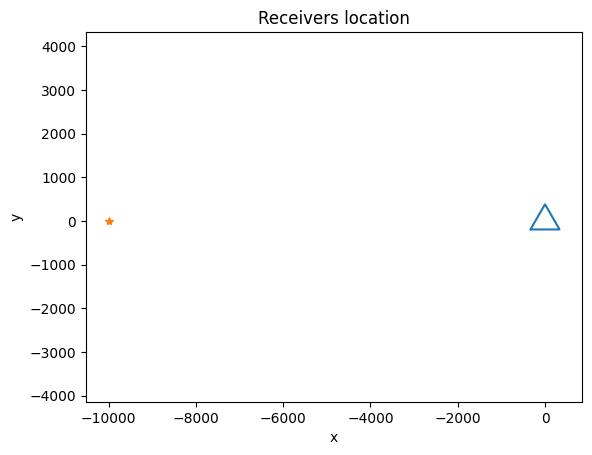

In [3]:
plt.plot(x, y)
plt.plot(xs, ys, "*")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Receivers location");

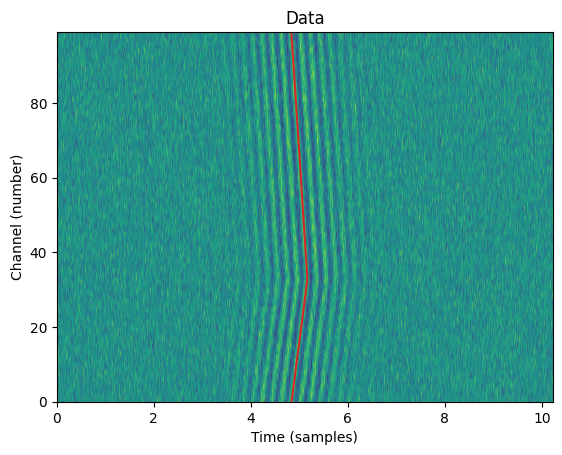

In [4]:
plt.pcolormesh(t, np.arange(nch), data, shading="gouraud")
plt.plot(toa, np.arange(nch), "C3")
plt.xlabel("Time (samples)")
plt.ylabel("Channel (number)")
plt.title("Data");

## Grid

In [5]:
theta = np.linspace(0, 2 * np.pi, 91)
speed = np.linspace(1e-15, 5_000, 51)
grid = polar_grid(theta, speed)


##  Beamform

In [6]:
frequency_band = (4.0, 6.0)
nperseg = 128

beamformers = {
    "a": MultitaperBeamformer(
        coords=coords,
        grid=grid,
        frequency_band=frequency_band,
        adaptative=False,
        n_tapers=3,
        n_sources=1,
    ),
    "b": SlidingBeamformer(
        coords=coords,
        grid=grid,
        frequency_band=frequency_band,
        nperseg=nperseg,
    ),
    "c": CorrBeamformer(
        coords=coords,
        grid=grid,
        frequency_band=frequency_band,
        nperseg=nperseg,
        mode="capon",
    ),
}


In [7]:
Ps = {name: beamformer(da) for name, beamformer in beamformers.items()}


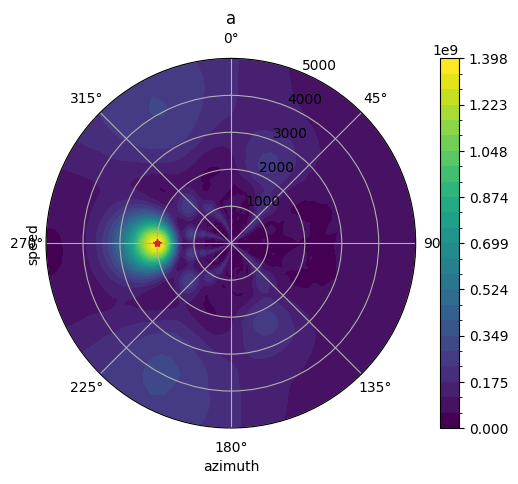

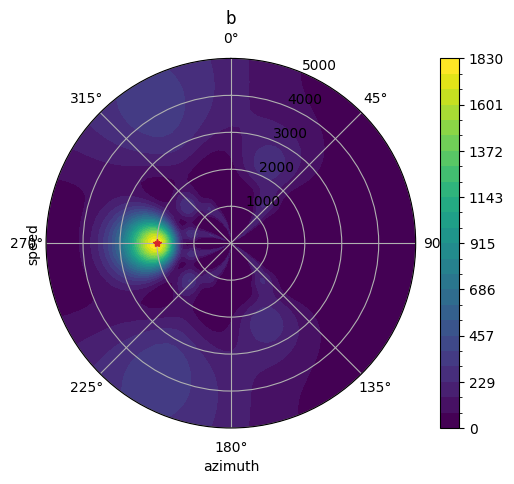

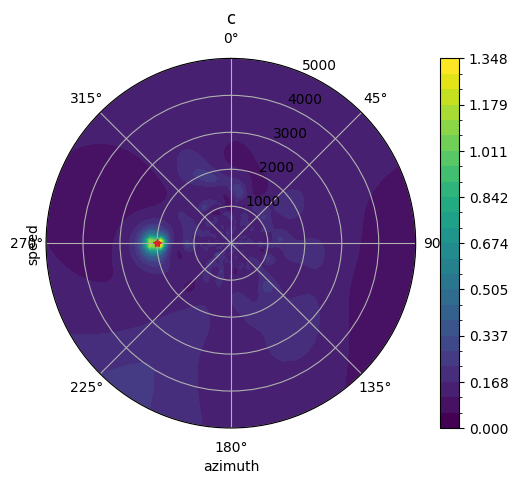

In [8]:
for name, P in Ps.items():
    if "time" in P.dims:
        P = P.mean("time")
    fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
    P.plot.contourf(ax=ax, x="azimuth", y="speed", cmap="viridis", levels=25, vmin=0.0)
    ax.plot(source_azimuth, source_speed, "C3*")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_title(name)


In [9]:
# P.sum("speed").plot.contourf(levels=25)